<a href="https://colab.research.google.com/github/DenisKai7/GroUp/blob/ml-training/GroUp_stunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dataset dari github

In [1]:
!git clone https://github.com/DenisKai7/GroUp.git

Cloning into 'GroUp'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 221 (delta 6), reused 35 (delta 0), pack-reused 168 (from 1)
Receiving objects: 100% (221/221), 1.35 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
%cd GroUp
!git checkout dataset

/content/GroUp
Branch 'dataset' set up to track remote branch 'dataset' from 'origin'.
Switched to a new branch 'dataset'


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


[I 2024-11-25 13:41:15,061] A new study created in memory with name: no-name-2116eae3-b008-4701-9d50-d8e1fae61c41
[I 2024-11-25 13:41:19,795] Trial 0 finished with value: 0.8465 and parameters: {'n_estimators': 242, 'max_depth': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.8465.
[I 2024-11-25 13:41:21,255] Trial 1 finished with value: 0.8365 and parameters: {'n_estimators': 183, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.8465.
[I 2024-11-25 13:41:23,683] Trial 2 finished with value: 0.8435 and parameters: {'n_estimators': 112, 'max_depth': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.8465.
[I 2024-11-25 13:41:26,588] Trial 3 finished with value: 0.8265 and parameters: {'n_estimators': 188, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.8465.
[I 2024-11-25 13:41:27,367] Trial 4 finished with value: 0.8395 and parameters: {'n_estimators': 128, 'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with valu

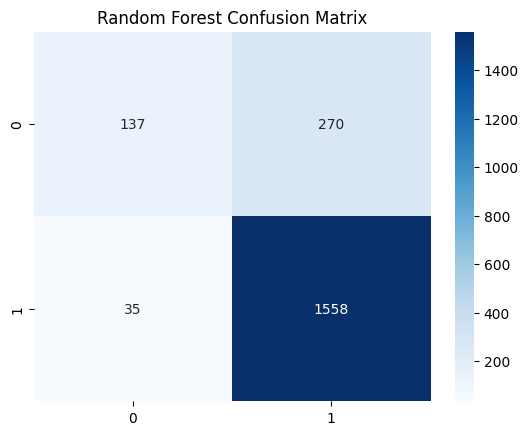

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
[I 2024-11-25 13:42:12,478] A new study created in memory with name: no-name-1b96a66b-d895-485f-b8c7-2f24354f5d68


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.34      0.47       407
           1       0.85      0.98      0.91      1593

    accuracy                           0.85      2000
   macro avg       0.82      0.66      0.69      2000
weighted avg       0.84      0.85      0.82      2000

Kasus Serupa:
       id toddlers Gender       Age  Birth Weight  Birth Length  Body Weight  \
6846         6847   Male  0.977547           2.7            49     1.376450   
8918         8919   Male  0.851331           2.9            49     1.376450   
7053         7054   Male  1.356197           3.1            49     1.667084   

      Body Length Breastfeeding  Stunting  Gender_Encoded  
6846     1.251385            No         1        0.782217  
8918     1.251385            No         1        0.782217  
7053     0.802260            No         1        0.782217  
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.

[I 2024-11-25 13:43:41,798] Trial 0 finished with value: 0.8562438250084162 and parameters: {'units1': 33, 'dropout1': 0.4199977728244486, 'units2': 90, 'dropout2': 0.2027278995126161}. Best is trial 0 with value: 0.8562438250084162.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.0069 - val_loss: 0.9914
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.0028 - val_loss: 0.9814
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9711 - val_loss: 0.9804
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0150 - val_loss: 0.9803
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9730 - val_loss: 0.9794
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9673 - val_loss: 0.9788
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9593 - val_loss: 0.9847
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9818 - val_loss: 0.9818
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9561 - val_loss: 0.9726
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9696 - val_loss: 0.9719
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9746 - val_loss: 0.9648
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 13:45:33,929] Trial 1 finished with value: 0.8972523011159063 and parameters: {'units1': 110, 'dropout1': 0.45481168505546676, 'units2': 91, 'dropout2': 0.2971372202971455}. Best is trial 0 with value: 0.8562438250084162.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1.0147 - val_loss: 0.9843
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9999 - val_loss: 0.9838
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9575 - val_loss: 0.9823
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9814 - val_loss: 0.9816
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9828 - val_loss: 0.9810
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9492 - val_loss: 0.9815
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9455 - val_loss: 0.9794
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9655 - val_loss: 0.9795
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9605 - val_loss: 0.9777
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.0031 - val_loss: 0.9672
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9821 - val_loss: 0.9582
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 13:48:36,109] Trial 2 finished with value: 0.9123111479698397 and parameters: {'units1': 106, 'dropout1': 0.2226647806717594, 'units2': 109, 'dropout2': 0.49048285578543216}. Best is trial 0 with value: 0.8562438250084162.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9933 - val_loss: 0.9982
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0083 - val_loss: 0.9819
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9532 - val_loss: 0.9842
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9577 - val_loss: 0.9804
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9748 - val_loss: 0.9811
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9502 - val_loss: 0.9828
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9721 - val_loss: 0.9772
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9622 - val_loss: 0.9745
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9692 - val_loss: 0.9718
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9562 - val_loss: 0.9667
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9344 - val_loss: 0.9730
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/s

[I 2024-11-25 13:50:11,868] Trial 3 finished with value: 0.8877818033882812 and parameters: {'units1': 33, 'dropout1': 0.4769413712408903, 'units2': 105, 'dropout2': 0.10857582846203649}. Best is trial 0 with value: 0.8562438250084162.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.0132 - val_loss: 0.9874
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9784 - val_loss: 0.9843
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9466 - val_loss: 0.9812
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9824 - val_loss: 0.9896
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9837 - val_loss: 0.9800
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9666 - val_loss: 0.9858
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9944 - val_loss: 0.9856
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9693 - val_loss: 0.9776
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9591 - val_loss: 0.9713
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9649 - val_loss: 0.9747
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9652 - val_loss: 0.9545
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 13:52:33,420] Trial 4 finished with value: 0.869686429476907 and parameters: {'units1': 91, 'dropout1': 0.4371461348132556, 'units2': 119, 'dropout2': 0.17536981214415936}. Best is trial 0 with value: 0.8562438250084162.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9885 - val_loss: 0.9946
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9792 - val_loss: 0.9879
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9820 - val_loss: 0.9812
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9631 - val_loss: 0.9802
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9807 - val_loss: 0.9854
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9888 - val_loss: 0.9794
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.0079 - val_loss: 0.9795
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9632 - val_loss: 0.9854
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9613 - val_loss: 0.9782
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9762 - val_loss: 0.9765
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9827 - val_loss: 0.9934
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s

[I 2024-11-25 13:54:12,324] Trial 5 finished with value: 0.8499512029789573 and parameters: {'units1': 112, 'dropout1': 0.3258018677452752, 'units2': 72, 'dropout2': 0.4216334375873724}. Best is trial 5 with value: 0.8499512029789573.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.0111 - val_loss: 0.9928
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0058 - val_loss: 0.9839
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9654 - val_loss: 0.9830
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9489 - val_loss: 0.9862
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9651 - val_loss: 0.9823
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0068 - val_loss: 0.9807
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9837 - val_loss: 0.9797
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9566 - val_loss: 0.9941
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9800 - val_loss: 0.9774
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9580 - val_loss: 0.9758
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9826 - val_loss: 0.9809
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/s

[I 2024-11-25 13:55:41,895] Trial 6 finished with value: 0.8703710756274404 and parameters: {'units1': 91, 'dropout1': 0.48729879697091405, 'units2': 60, 'dropout2': 0.4825980291943702}. Best is trial 5 with value: 0.8499512029789573.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.0109 - val_loss: 0.9866
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0007 - val_loss: 0.9828
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9844 - val_loss: 0.9833
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9733 - val_loss: 0.9817
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0069 - val_loss: 0.9788
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9776 - val_loss: 0.9814
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9667 - val_loss: 0.9805
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9570 - val_loss: 0.9843
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.0056 - val_loss: 0.9735
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9612 - val_loss: 0.9720
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9560 - val_loss: 0.9680
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/

[I 2024-11-25 13:57:15,014] Trial 7 finished with value: 0.8500948333768347 and parameters: {'units1': 72, 'dropout1': 0.2860322354740153, 'units2': 45, 'dropout2': 0.3601547996424409}. Best is trial 5 with value: 0.8499512029789573.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0215 - val_loss: 0.9885
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.9778 - val_loss: 0.9836
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9559 - val_loss: 0.9812
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9535 - val_loss: 0.9825
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9553 - val_loss: 0.9820
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9716 - val_loss: 0.9818
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9741 - val_loss: 0.9787
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9552 - val_loss: 0.9776
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9381 - val_loss: 0.9782
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9776 - val_loss: 0.9777
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9637 - val_loss: 0.9645
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms

[I 2024-11-25 13:58:53,188] Trial 8 finished with value: 0.8642331096910469 and parameters: {'units1': 78, 'dropout1': 0.2368443486154428, 'units2': 87, 'dropout2': 0.14882632197472276}. Best is trial 5 with value: 0.8499512029789573.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9963 - val_loss: 0.9850
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9840 - val_loss: 0.9846
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9837 - val_loss: 0.9819
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9631 - val_loss: 0.9833
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9618 - val_loss: 0.9790
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9730 - val_loss: 0.9784
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9789 - val_loss: 0.9829
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9425 - val_loss: 0.9852
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9792 - val_loss: 0.9775
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9549 - val_loss: 0.9750
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9450 - val_loss: 0.9731
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/s

[I 2024-11-25 14:00:31,318] Trial 9 finished with value: 0.8481321557545977 and parameters: {'units1': 98, 'dropout1': 0.4637824070663681, 'units2': 44, 'dropout2': 0.1640384639132812}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.0250 - val_loss: 0.9883
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9644 - val_loss: 0.9816
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9582 - val_loss: 0.9804
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9887 - val_loss: 0.9798
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9659 - val_loss: 0.9790
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9579 - val_loss: 0.9773
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9676 - val_loss: 0.9761
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9785 - val_loss: 0.9784
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9525 - val_loss: 0.9707
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9549 - val_loss: 0.9786
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9234 - val_loss: 0.9529
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:02:22,850] Trial 10 finished with value: 0.8566410645852598 and parameters: {'units1': 126, 'dropout1': 0.10978608520753486, 'units2': 33, 'dropout2': 0.23036842402520696}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.0216 - val_loss: 0.9872
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.9796 - val_loss: 0.9912
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0127 - val_loss: 0.9798
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9607 - val_loss: 0.9804
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.9806 - val_loss: 0.9798
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9881 - val_loss: 0.9873
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9663 - val_loss: 0.9791
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9655 - val_loss: 0.9762
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.0045 - val_loss: 0.9760
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9636 - val_loss: 0.9828
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9747 - val_loss: 0.9716
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:04:36,539] Trial 11 finished with value: 0.8549769820643051 and parameters: {'units1': 122, 'dropout1': 0.3617456769075312, 'units2': 63, 'dropout2': 0.38635595031043785}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9832 - val_loss: 0.9908
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9989 - val_loss: 0.9837
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9828 - val_loss: 0.9869
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9715 - val_loss: 0.9837
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9717 - val_loss: 0.9803
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9629 - val_loss: 0.9859
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9559 - val_loss: 0.9798
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9636 - val_loss: 0.9803
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9858 - val_loss: 0.9985
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9498 - val_loss: 0.9795
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9841 - val_loss: 0.9794
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

[I 2024-11-25 14:06:18,887] Trial 12 finished with value: 0.8579243500641959 and parameters: {'units1': 61, 'dropout1': 0.35697100726105657, 'units2': 63, 'dropout2': 0.41382082123877006}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.0347 - val_loss: 0.9957
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9908 - val_loss: 0.9824
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9908 - val_loss: 0.9868
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9723 - val_loss: 0.9967
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9536 - val_loss: 0.9791
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9389 - val_loss: 0.9795
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9502 - val_loss: 0.9789
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9959 - val_loss: 0.9899
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9855 - val_loss: 0.9742
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9828 - val_loss: 0.9687
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9745 - val_loss: 0.9628
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

[I 2024-11-25 14:07:33,376] Trial 13 finished with value: 0.8715067878297396 and parameters: {'units1': 104, 'dropout1': 0.3714367103925532, 'units2': 48, 'dropout2': 0.28137747770563587}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9668 - val_loss: 0.9884
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9883 - val_loss: 0.9833
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9682 - val_loss: 0.9878
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9610 - val_loss: 0.9908
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9659 - val_loss: 0.9796
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9936 - val_loss: 0.9903
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9627 - val_loss: 0.9800
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9887 - val_loss: 0.9879
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9915 - val_loss: 0.9900
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9538 - val_loss: 0.9758
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9542 - val_loss: 0.9603
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/

[I 2024-11-25 14:09:02,349] Trial 14 finished with value: 0.8557035742487371 and parameters: {'units1': 94, 'dropout1': 0.14382468820328465, 'units2': 74, 'dropout2': 0.34933281313161973}. Best is trial 9 with value: 0.8481321557545977.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9912 - val_loss: 0.9884
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9834 - val_loss: 0.9843
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9949 - val_loss: 0.9833
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9589 - val_loss: 0.9806
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0018 - val_loss: 0.9789
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9719 - val_loss: 0.9800
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9939 - val_loss: 0.9792
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9807 - val_loss: 0.9772
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9770 - val_loss: 0.9769
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9648 - val_loss: 0.9733
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9806 - val_loss: 0.9696
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms

[I 2024-11-25 14:10:36,472] Trial 15 finished with value: 0.8472358470458717 and parameters: {'units1': 114, 'dropout1': 0.3014884902889591, 'units2': 33, 'dropout2': 0.2489586295013823}. Best is trial 15 with value: 0.8472358470458717.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9761 - val_loss: 0.9965
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9741 - val_loss: 0.9835
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9765 - val_loss: 0.9807
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9913 - val_loss: 0.9835
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9812 - val_loss: 0.9843
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9719 - val_loss: 0.9830
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9715 - val_loss: 0.9779
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9801 - val_loss: 0.9782
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9805 - val_loss: 0.9797
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9892 - val_loss: 0.9800
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9721 - val_loss: 0.9851
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

[I 2024-11-25 14:12:01,894] Trial 16 finished with value: 0.8714307533213601 and parameters: {'units1': 58, 'dropout1': 0.2154158807424421, 'units2': 32, 'dropout2': 0.24464278030551823}. Best is trial 15 with value: 0.8472358470458717.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.0086 - val_loss: 0.9833
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0119 - val_loss: 0.9857
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9792 - val_loss: 0.9822
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9466 - val_loss: 0.9900
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9886 - val_loss: 0.9800
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.9784 - val_loss: 0.9825
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9786 - val_loss: 0.9745
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9834 - val_loss: 0.9713
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9940 - val_loss: 0.9698
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9422 - val_loss: 0.9607
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9389 - val_loss: 0.9494
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:13:37,063] Trial 17 finished with value: 0.9020239573748892 and parameters: {'units1': 118, 'dropout1': 0.27522564309078246, 'units2': 45, 'dropout2': 0.10360624490325682}. Best is trial 15 with value: 0.8472358470458717.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0047 - val_loss: 0.9881
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9626 - val_loss: 0.9860
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9906 - val_loss: 0.9804
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9865 - val_loss: 0.9801
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9831 - val_loss: 0.9812
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9795 - val_loss: 0.9797
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9907 - val_loss: 0.9773
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9686 - val_loss: 0.9743
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9521 - val_loss: 0.9728
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9731 - val_loss: 0.9810
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9456 - val_loss: 0.9658
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/s

[I 2024-11-25 14:15:47,625] Trial 18 finished with value: 0.8386234472309252 and parameters: {'units1': 98, 'dropout1': 0.40485596030079785, 'units2': 52, 'dropout2': 0.25924098251556027}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0255 - val_loss: 0.9870
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9610 - val_loss: 0.9843
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9663 - val_loss: 0.9817
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9734 - val_loss: 0.9798
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9665 - val_loss: 0.9793
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9838 - val_loss: 0.9792
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9643 - val_loss: 0.9802
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9741 - val_loss: 0.9797
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9870 - val_loss: 0.9773
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9687 - val_loss: 0.9749
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9911 - val_loss: 0.9802
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/st

[I 2024-11-25 14:17:08,412] Trial 19 finished with value: 0.897309734835865 and parameters: {'units1': 83, 'dropout1': 0.40276721940231763, 'units2': 38, 'dropout2': 0.2634289536290654}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.9706 - val_loss: 0.9839
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9519 - val_loss: 0.9823
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9626 - val_loss: 0.9839
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9331 - val_loss: 0.9825
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9669 - val_loss: 0.9801
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9782 - val_loss: 0.9819
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9841 - val_loss: 0.9781
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9482 - val_loss: 0.9796
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9395 - val_loss: 0.9714
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9660 - val_loss: 0.9791
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9804 - val_loss: 0.9654
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 

[I 2024-11-25 14:18:45,137] Trial 20 finished with value: 0.8699464823458518 and parameters: {'units1': 116, 'dropout1': 0.3194717130736254, 'units2': 55, 'dropout2': 0.3160516792071603}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0111 - val_loss: 0.9869
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9699 - val_loss: 0.9973
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0091 - val_loss: 0.9910
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9558 - val_loss: 0.9870
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9836 - val_loss: 0.9817
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9947 - val_loss: 0.9821
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9688 - val_loss: 0.9780
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9580 - val_loss: 0.9784
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9625 - val_loss: 0.9778
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9889 - val_loss: 0.9744
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9630 - val_loss: 0.9724
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/st

[I 2024-11-25 14:20:10,957] Trial 21 finished with value: 0.8803974965384823 and parameters: {'units1': 101, 'dropout1': 0.4988618618375079, 'units2': 51, 'dropout2': 0.2109000736168144}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9755 - val_loss: 0.9903
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9613 - val_loss: 0.9813
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9646 - val_loss: 0.9844
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9808 - val_loss: 0.9831
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9697 - val_loss: 0.9814
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9987 - val_loss: 0.9781
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9783 - val_loss: 0.9779
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9735 - val_loss: 0.9776
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9725 - val_loss: 0.9745
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9429 - val_loss: 0.9715
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9367 - val_loss: 0.9742
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/

[I 2024-11-25 14:22:04,424] Trial 22 finished with value: 0.8430777693286309 and parameters: {'units1': 98, 'dropout1': 0.4033400076967047, 'units2': 42, 'dropout2': 0.17349244956075235}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.0099 - val_loss: 0.9895
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0015 - val_loss: 0.9813
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9887 - val_loss: 0.9804
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9901 - val_loss: 0.9788
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9468 - val_loss: 0.9808
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9859 - val_loss: 0.9830
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9766 - val_loss: 0.9818
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9871 - val_loss: 0.9769
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9852 - val_loss: 0.9782
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9944 - val_loss: 0.9727
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9572 - val_loss: 0.9671
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/s

[I 2024-11-25 14:23:30,848] Trial 23 finished with value: 0.851630347110179 and parameters: {'units1': 81, 'dropout1': 0.3950011356814284, 'units2': 40, 'dropout2': 0.19623153000112192}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.0259 - val_loss: 0.9887
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9951 - val_loss: 0.9859
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9581 - val_loss: 0.9809
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9841 - val_loss: 0.9842
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9592 - val_loss: 0.9866
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9804 - val_loss: 0.9804
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9557 - val_loss: 0.9859
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9367 - val_loss: 0.9762
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9621 - val_loss: 0.9729
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9586 - val_loss: 0.9751
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9441 - val_loss: 0.9606
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:25:36,672] Trial 24 finished with value: 0.8733441636261005 and parameters: {'units1': 128, 'dropout1': 0.32759267060729075, 'units2': 54, 'dropout2': 0.25423255693426544}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0158 - val_loss: 0.9848
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9875 - val_loss: 0.9847
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9896 - val_loss: 0.9796
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9908 - val_loss: 0.9924
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9735 - val_loss: 0.9830
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9927 - val_loss: 0.9800
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9770 - val_loss: 0.9780
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9760 - val_loss: 0.9787
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9911 - val_loss: 0.9728
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9748 - val_loss: 0.9742
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9723 - val_loss: 0.9725
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/

[I 2024-11-25 14:27:21,282] Trial 25 finished with value: 0.8516156281425805 and parameters: {'units1': 110, 'dropout1': 0.25738429562310117, 'units2': 32, 'dropout2': 0.13901866172470126}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9914 - val_loss: 0.9871
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9871 - val_loss: 0.9822
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9881 - val_loss: 0.9826
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9913 - val_loss: 0.9802
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9917 - val_loss: 0.9862
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9946 - val_loss: 0.9774
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9685 - val_loss: 0.9783
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9686 - val_loss: 0.9725
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9511 - val_loss: 0.9724
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9647 - val_loss: 0.9673
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9687 - val_loss: 0.9598
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/

[I 2024-11-25 14:28:47,635] Trial 26 finished with value: 0.8527001247626639 and parameters: {'units1': 91, 'dropout1': 0.37865321452100614, 'units2': 70, 'dropout2': 0.32415721929444363}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9811 - val_loss: 0.9929
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9827 - val_loss: 0.9837
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9779 - val_loss: 0.9813
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9901 - val_loss: 0.9865
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.9667 - val_loss: 0.9805
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9754 - val_loss: 0.9817
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9646 - val_loss: 0.9822
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9683 - val_loss: 0.9966
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9613 - val_loss: 0.9763
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9639 - val_loss: 0.9839
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9848 - val_loss: 0.9715
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

[I 2024-11-25 14:30:00,173] Trial 27 finished with value: 0.8648326019882188 and parameters: {'units1': 70, 'dropout1': 0.43219666029426695, 'units2': 56, 'dropout2': 0.22346263771428668}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.0108 - val_loss: 1.0073
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9900 - val_loss: 0.9857
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9984 - val_loss: 0.9801
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9604 - val_loss: 0.9808
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9890 - val_loss: 0.9809
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9847 - val_loss: 0.9797
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9851 - val_loss: 0.9793
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9532 - val_loss: 0.9754
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9722 - val_loss: 0.9720
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9537 - val_loss: 0.9734
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9397 - val_loss: 0.9611
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/

[I 2024-11-25 14:31:39,008] Trial 28 finished with value: 0.8502715639378392 and parameters: {'units1': 101, 'dropout1': 0.1580233505092593, 'units2': 39, 'dropout2': 0.27227912637857904}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.9819 - val_loss: 0.9856
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9738 - val_loss: 0.9822
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9590 - val_loss: 0.9860
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9840 - val_loss: 0.9795
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9899 - val_loss: 0.9788
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9771 - val_loss: 0.9796
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9710 - val_loss: 0.9858
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9524 - val_loss: 0.9738
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9595 - val_loss: 0.9724
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9603 - val_loss: 0.9730
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9812 - val_loss: 0.9763
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:34:49,635] Trial 29 finished with value: 0.8524789108602224 and parameters: {'units1': 120, 'dropout1': 0.4009780213263937, 'units2': 39, 'dropout2': 0.18711728477812256}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0253 - val_loss: 1.0134
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.0011 - val_loss: 0.9845
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9778 - val_loss: 0.9807
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9614 - val_loss: 0.9862
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9639 - val_loss: 0.9790
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9601 - val_loss: 0.9774
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9510 - val_loss: 0.9896
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9771 - val_loss: 0.9762
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0027 - val_loss: 0.9729
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9464 - val_loss: 0.9794
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9598 - val_loss: 0.9651
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms

[I 2024-11-25 14:36:12,951] Trial 30 finished with value: 0.9463547766764872 and parameters: {'units1': 84, 'dropout1': 0.34322849652742093, 'units2': 82, 'dropout2': 0.20895626793144595}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9915 - val_loss: 1.0223
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9901 - val_loss: 0.9838
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9841 - val_loss: 0.9833
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9741 - val_loss: 0.9915
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9793 - val_loss: 0.9796
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9619 - val_loss: 0.9792
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9840 - val_loss: 0.9772
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9623 - val_loss: 0.9768
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9787 - val_loss: 0.9751
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9640 - val_loss: 0.9699
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9747 - val_loss: 0.9669
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/

[I 2024-11-25 14:37:30,501] Trial 31 finished with value: 0.8602128741641387 and parameters: {'units1': 97, 'dropout1': 0.46166836105760356, 'units2': 45, 'dropout2': 0.16114562989805017}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0165 - val_loss: 0.9885
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9866 - val_loss: 0.9857
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9753 - val_loss: 0.9839
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9682 - val_loss: 0.9789
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9657 - val_loss: 0.9789
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9886 - val_loss: 0.9787
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9837 - val_loss: 0.9763
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9733 - val_loss: 0.9758
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9864 - val_loss: 0.9820
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9645 - val_loss: 0.9730
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9481 - val_loss: 0.9691
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

[I 2024-11-25 14:38:57,643] Trial 32 finished with value: 0.8476082452825442 and parameters: {'units1': 107, 'dropout1': 0.4461154513930172, 'units2': 49, 'dropout2': 0.13013741304371612}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.9875 - val_loss: 0.9835
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9617 - val_loss: 0.9811
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9894 - val_loss: 0.9814
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9859 - val_loss: 0.9816
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9960 - val_loss: 0.9786
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9710 - val_loss: 0.9803
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9643 - val_loss: 0.9838
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9357 - val_loss: 0.9747
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9560 - val_loss: 0.9705
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9704 - val_loss: 0.9671
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9529 - val_loss: 0.9751
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/

[I 2024-11-25 14:40:10,998] Trial 33 finished with value: 0.8793587359859454 and parameters: {'units1': 107, 'dropout1': 0.438943545638092, 'units2': 51, 'dropout2': 0.12105361143033905}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.0069 - val_loss: 0.9827
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.9825 - val_loss: 0.9799
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9821 - val_loss: 0.9840
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9900 - val_loss: 0.9816
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9617 - val_loss: 0.9833
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9422 - val_loss: 0.9821
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9516 - val_loss: 0.9869
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2024-11-25 14:40:45,605] Trial 34 finished with value: 0.9766940332863145 and parameters: {'units1': 113, 'dropout1': 0.4157481210119052, 'units2': 61, 'dropout2': 0.132365346055312}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.0218 - val_loss: 0.9842
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0066 - val_loss: 0.9805
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9671 - val_loss: 0.9812
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9632 - val_loss: 0.9829
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9847 - val_loss: 0.9786
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9587 - val_loss: 0.9787
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9853 - val_loss: 0.9840
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9802 - val_loss: 0.9772
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9512 - val_loss: 0.9755
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9470 - val_loss: 0.9690
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9941 - val_loss: 0.9727
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:43:28,295] Trial 35 finished with value: 0.8738595244804687 and parameters: {'units1': 107, 'dropout1': 0.42237188581107765, 'units2': 93, 'dropout2': 0.295773698320202}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.0160 - val_loss: 0.9855
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9950 - val_loss: 0.9966
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9855 - val_loss: 0.9826
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9497 - val_loss: 0.9822
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9908 - val_loss: 0.9793
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9743 - val_loss: 0.9774
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9736 - val_loss: 0.9780
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9713 - val_loss: 0.9730
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9661 - val_loss: 0.9693
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9716 - val_loss: 0.9626
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9303 - val_loss: 0.9566
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/

[I 2024-11-25 14:45:35,637] Trial 36 finished with value: 0.9055365021230393 and parameters: {'units1': 32, 'dropout1': 0.19782178451503707, 'units2': 98, 'dropout2': 0.18031942917597776}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 1.0062 - val_loss: 0.9865
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9579 - val_loss: 0.9879
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9912 - val_loss: 0.9818
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9664 - val_loss: 0.9824
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9710 - val_loss: 0.9826
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9669 - val_loss: 0.9797
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9463 - val_loss: 0.9857
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9794 - val_loss: 0.9803
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9812 - val_loss: 0.9782
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9433 - val_loss: 0.9689
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9665 - val_loss: 0.9792
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:48:38,482] Trial 37 finished with value: 0.8447909244963417 and parameters: {'units1': 42, 'dropout1': 0.4477687167746458, 'units2': 127, 'dropout2': 0.2430601690323192}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9882 - val_loss: 0.9859
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9973 - val_loss: 0.9828
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9684 - val_loss: 0.9816
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.9485 - val_loss: 0.9802
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9644 - val_loss: 0.9839
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9754 - val_loss: 0.9894
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9739 - val_loss: 0.9798
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9739 - val_loss: 0.9783
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9853 - val_loss: 0.9750
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9581 - val_loss: 0.9707
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9384 - val_loss: 0.9587
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:50:45,504] Trial 38 finished with value: 0.8575792312955686 and parameters: {'units1': 46, 'dropout1': 0.3837776712261916, 'units2': 120, 'dropout2': 0.24004828293356575}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.9787 - val_loss: 0.9869
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9806 - val_loss: 0.9889
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9918 - val_loss: 0.9820
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9481 - val_loss: 0.9819
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9608 - val_loss: 0.9822
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.9773 - val_loss: 0.9814
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9771 - val_loss: 0.9796
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9781 - val_loss: 0.9849
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9437 - val_loss: 0.9754
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.9713 - val_loss: 0.9750
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9709 - val_loss: 0.9912
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:53:06,917] Trial 39 finished with value: 0.865323723584388 and parameters: {'units1': 39, 'dropout1': 0.47659335277748016, 'units2': 128, 'dropout2': 0.283858374529974}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.0218 - val_loss: 0.9847
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9839 - val_loss: 0.9867
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9845 - val_loss: 0.9818
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9618 - val_loss: 0.9800
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9579 - val_loss: 0.9909
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9548 - val_loss: 0.9814
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9571 - val_loss: 0.9762
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9668 - val_loss: 0.9877
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9309 - val_loss: 0.9681
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9976 - val_loss: 0.9654
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9536 - val_loss: 0.9577
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11

[I 2024-11-25 14:55:40,162] Trial 40 finished with value: 0.9086670427629245 and parameters: {'units1': 88, 'dropout1': 0.30362106603228867, 'units2': 105, 'dropout2': 0.3229299551673406}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.9780 - val_loss: 0.9887
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9907 - val_loss: 0.9827
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.9860 - val_loss: 0.9835
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.0058 - val_loss: 0.9823
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9851 - val_loss: 0.9816
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9743 - val_loss: 0.9797
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.9798 - val_loss: 0.9804
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9603 - val_loss: 0.9773
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9719 - val_loss: 0.9842
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9589 - val_loss: 0.9848
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9525 - val_loss: 0.9549
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-11-25 14:59:06,191] Trial 41 finished with value: 0.8528733586292189 and parameters: {'units1': 112, 'dropout1': 0.44866780345691126, 'units2': 112, 'dropout2': 0.22305719389759388}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0006 - val_loss: 0.9882
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9855 - val_loss: 0.9853
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9652 - val_loss: 0.9821
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9689 - val_loss: 0.9808
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9629 - val_loss: 0.9822
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9924 - val_loss: 0.9796
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9549 - val_loss: 0.9782
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9733 - val_loss: 0.9775
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9831 - val_loss: 0.9756
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9584 - val_loss: 0.9738
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9653 - val_loss: 0.9734
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

[I 2024-11-25 15:00:54,457] Trial 42 finished with value: 0.9178001281744997 and parameters: {'units1': 53, 'dropout1': 0.41491091109206124, 'units2': 35, 'dropout2': 0.16327328861111695}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9930 - val_loss: 0.9871
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0026 - val_loss: 0.9941
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0025 - val_loss: 0.9811
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9832 - val_loss: 0.9799
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9774 - val_loss: 0.9829
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9630 - val_loss: 0.9788
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9781 - val_loss: 0.9770
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9518 - val_loss: 1.0053
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9572 - val_loss: 0.9805
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9719 - val_loss: 0.9718
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9609 - val_loss: 0.9725
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

[I 2024-11-25 15:02:37,814] Trial 43 finished with value: 0.8431897072845128 and parameters: {'units1': 72, 'dropout1': 0.4758455373330129, 'units2': 67, 'dropout2': 0.20509800675481205}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.0107 - val_loss: 0.9851
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9795 - val_loss: 0.9812
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9806 - val_loss: 0.9798
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9690 - val_loss: 0.9886
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9717 - val_loss: 0.9814
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9627 - val_loss: 0.9797
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9963 - val_loss: 0.9788
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9848 - val_loss: 0.9797
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0062 - val_loss: 0.9783
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9831 - val_loss: 0.9755
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9644 - val_loss: 0.9756
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

[I 2024-11-25 15:04:14,183] Trial 44 finished with value: 0.8650544360624888 and parameters: {'units1': 75, 'dropout1': 0.4831906472891364, 'units2': 69, 'dropout2': 0.20533876303102094}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.0006 - val_loss: 0.9899
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9597 - val_loss: 0.9825
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9879 - val_loss: 0.9813
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9844 - val_loss: 0.9813
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9703 - val_loss: 0.9820
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9574 - val_loss: 0.9793
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0010 - val_loss: 0.9793
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9703 - val_loss: 0.9782
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9690 - val_loss: 0.9772
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9766 - val_loss: 0.9974
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9683 - val_loss: 0.9717
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/

[I 2024-11-25 15:05:50,270] Trial 45 finished with value: 0.860935358049643 and parameters: {'units1': 67, 'dropout1': 0.46240394954490355, 'units2': 75, 'dropout2': 0.2460056558364645}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.0083 - val_loss: 0.9945
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9845 - val_loss: 0.9928
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9824 - val_loss: 0.9807
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9797 - val_loss: 0.9859
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9819 - val_loss: 0.9815
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9854 - val_loss: 0.9811
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9666 - val_loss: 0.9797
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9709 - val_loss: 0.9831
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9710 - val_loss: 0.9781
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9919 - val_loss: 0.9751
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9691 - val_loss: 0.9710
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/s

[I 2024-11-25 15:08:06,430] Trial 46 finished with value: 0.8491177358876608 and parameters: {'units1': 42, 'dropout1': 0.49155336481949086, 'units2': 80, 'dropout2': 0.264284718683128}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.0169 - val_loss: 0.9866
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9636 - val_loss: 0.9936
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9980 - val_loss: 0.9816
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9736 - val_loss: 0.9819
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9702 - val_loss: 0.9787
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9707 - val_loss: 0.9804
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9580 - val_loss: 0.9818
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9680 - val_loss: 0.9774
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9627 - val_loss: 0.9743
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9589 - val_loss: 0.9736
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9718 - val_loss: 0.9808
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/s

[I 2024-11-25 15:10:29,811] Trial 47 finished with value: 0.8418215439703123 and parameters: {'units1': 50, 'dropout1': 0.3487312556790184, 'units2': 85, 'dropout2': 0.30443356735674093}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0256 - val_loss: 0.9890
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9724 - val_loss: 0.9812
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9751 - val_loss: 0.9808
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9492 - val_loss: 0.9799
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9616 - val_loss: 0.9793
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9841 - val_loss: 0.9785
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9808 - val_loss: 0.9798
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9802 - val_loss: 0.9767
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9772 - val_loss: 0.9781
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9770 - val_loss: 0.9759
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9384 - val_loss: 0.9723
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

[I 2024-11-25 15:12:33,043] Trial 48 finished with value: 0.8789026335041359 and parameters: {'units1': 51, 'dropout1': 0.3491873346139582, 'units2': 67, 'dropout2': 0.3069735276465363}. Best is trial 18 with value: 0.8386234472309252.


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.9886 - val_loss: 0.9996
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0026 - val_loss: 0.9824
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9700 - val_loss: 0.9826
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9808 - val_loss: 0.9814
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9489 - val_loss: 0.9819
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9755 - val_loss: 0.9804
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9716 - val_loss: 0.9808
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9637 - val_loss: 0.9792
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9652 - val_loss: 0.9811
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9798 - val_loss: 0.9758
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9663 - val_loss: 0.9786
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

[I 2024-11-25 15:13:49,297] Trial 49 finished with value: 0.8782533115561207 and parameters: {'units1': 59, 'dropout1': 0.428105341876504, 'units2': 80, 'dropout2': 0.2938994721840474}. Best is trial 18 with value: 0.8386234472309252.


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np

# Load Dataset
data_path = '/content/GroUp/Stunting_Dataset.csv'
nutrition_data_path = '/content/GroUp/nutrition.csv'
data = pd.read_csv(data_path)
nutrition_data = pd.read_csv(nutrition_data_path)

class DataPreprocessor:
    def __init__(self, data):
        self.data = data
        self.label_encoder = LabelEncoder()
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def preprocess(self):
        # Encode categorical variables
        self.data['Gender_Encoded'] = self.label_encoder.fit_transform(self.data['Gender'])

        # Define features and target
        features = ['Age', 'Body Weight', 'Body Length', 'Gender_Encoded']
        target = 'Stunting'

        # Encode target variable if it's categorical
        if self.data[target].dtype == 'object':
            self.data[target] = self.label_encoder.fit_transform(self.data[target])

        # Scale features
        self.data[features] = self.scaler_X.fit_transform(self.data[features])

        # Target scaling for regression in LSTM
        y_regression = self.scaler_y.fit_transform(self.data[[target]])

        X = self.data[features]
        y_classification = self.data[target]
        return X, y_classification, y_regression

preprocessor = DataPreprocessor(data)
X, y_classification, y_regression = preprocessor.preprocess()

class ModelTrainer:
    def __init__(self):
        self.models = {}

    def train_random_forest(self, X, y):
        # Train-test split for Random Forest
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }

            rf = RandomForestClassifier(**params)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            return accuracy_score(y_test, y_pred)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)

        best_rf = RandomForestClassifier(**study.best_params)
        best_rf.fit(X_train, y_train)
        y_pred_rf = best_rf.predict(X_test)

        # Visualize Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_rf)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Random Forest Confusion Matrix')
        plt.show()

        print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
        return best_rf, study.best_params

trainer = ModelTrainer()
rf_model, rf_params = trainer.train_random_forest(X, y_classification)

# KNN Training
knn = NearestNeighbors(n_neighbors=3)
knn.fit(X)

def find_similar_cases(input_data, X, knn):
    distances, indices = knn.kneighbors(input_data)
    return indices.flatten()

sample_input = pd.DataFrame({
    'Age': [24],
    'Body Weight': [10],
    'Body Length': [80],
    'Gender': ['Yes'],
})

sample_input['Gender_Encoded'] = preprocessor.label_encoder.transform(sample_input['Gender'])

sample_features = ['Age', 'Body Weight', 'Body Length', 'Gender_Encoded']
processed_sample_input = preprocessor.scaler_X.transform(sample_input[sample_features])

similar_cases_indices = find_similar_cases(processed_sample_input, X, knn)
similar_cases_data = data.iloc[similar_cases_indices]
print("Kasus Serupa:\n", similar_cases_data)

class NutritionRecommender:
    def __init__(self, nutrition_data):
        self.nutrition_data = nutrition_data

    def recommend_nutrition(self, age, stunting_status, weight):
        # Filter data based on toddler's age
        filtered_data = self.nutrition_data[
            (self.nutrition_data['usia minimal(bulan)'] <= age) &
            (self.nutrition_data['usia maksimal(bulan)'] >= age)
        ]

        # Further filter based on stunting status
        if stunting_status == 'Stunting':
            filtered_data = filtered_data[
                (filtered_data['protein (g)'] > filtered_data['protein (g)'].median()) &
                (filtered_data['kalori'] > filtered_data['kalori'].median())
            ]

        # Adjust portion size based on weight
        filtered_data.loc[:, 'adjusted_portion'] = filtered_data['kalori'] * (weight / 10)

        # Split into categories
        categories = ['makanan', 'sayuran', 'buah', 'minuman']
        recommended_by_category = {}
        for category in categories:
            category_data = filtered_data[filtered_data['kategori'] == category]
            # Sort by adjusted portion size and select top 3 items per category
            recommended_by_category[category] = category_data.sort_values('adjusted_portion', ascending=False).head(3)

        # Construct meal plans for pagi, siang, dan sore
        meal_plan = {
            'pagi': {cat: recommended_by_category[cat].iloc[0] for cat in categories if not recommended_by_category[cat].empty},
            'siang': {cat: recommended_by_category[cat].iloc[1] for cat in categories if len(recommended_by_category[cat]) > 1},
            'sore': {cat: recommended_by_category[cat].iloc[2] for cat in categories if len(recommended_by_category[cat]) > 2},
        }

        return meal_plan

recommender = NutritionRecommender(nutrition_data)

def create_lstm_model(trial, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(trial.suggest_int('units1', 32, 128), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout1', 0.1, 0.5)))
    model.add(LSTM(trial.suggest_int('units2', 32, 128)))
    model.add(Dropout(trial.suggest_float('dropout2', 0.1, 0.5)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def objective(trial):
    input_shape = (X.shape[1], 1)
    model = create_lstm_model(trial, input_shape)
    X_scaled_lstm = preprocessor.scaler_X.transform(X)
    X_lstm = np.expand_dims(X_scaled_lstm, axis=2)
    y_lstm = y_regression.flatten()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    y_pred_lstm = model.predict(X_lstm)
    mse_lstm = mean_squared_error(y_lstm, y_pred_lstm)
    return mse_lstm

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best LSTM model
input_shape = (X.shape[1], 1)
best_lstm_model = create_lstm_model(study.best_trial, input_shape)



In [5]:
class StuntingManagementSystemTest:
    def __init__(self):
        self.preprocessor = DataPreprocessor(data)
        self.X, self.y_classification, self.y_regression = self.preprocessor.preprocess()  # Change here
        self.lstm_model = best_lstm_model

    def test_lstm_mse(self):
        X_scaled_lstm = self.preprocessor.scaler_X.transform(self.X)
        X_lstm = np.expand_dims(X_scaled_lstm, axis=2)
        y_lstm = self.preprocessor.scaler_y.transform(self.y_regression.reshape(-1, 1)).flatten()  # Change here
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)
        self.lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
        y_pred_lstm = self.lstm_model.predict(X_lstm)
        mse_lstm = mean_squared_error(y_lstm, y_pred_lstm)
        print(f"LSTM Mean Squared Error: {mse_lstm}")
        return mse_lstm

    def predict_future_growth(self, input_data):
        input_scaled = self.preprocessor.scaler_X.transform(input_data)
        input_reshaped = np.expand_dims(input_scaled, axis=2)
        predictions = self.lstm_model.predict(input_reshaped)
        future_growth = self.preprocessor.scaler_y.inverse_transform(predictions).flatten()
        return future_growth

# Create an instance of the StuntingManagementSystemTest class
tester = StuntingManagementSystemTest()
tester.test_lstm_mse()

# Simulate new toddler data input
new_toddler_data = pd.DataFrame({
    'Name': ['Sample Toddler'],
    'Age': [30],
    'Body Weight': [11],
    'Body Length': [85],
    'Gender': ['Yes'],
})

# Encode and scale new data
new_toddler_data['Gender_Encoded'] = preprocessor.label_encoder.transform(new_toddler_data['Gender'])
new_features = ['Age', 'Body Weight', 'Body Length', 'Gender_Encoded']
processed_new_toddler_data = preprocessor.scaler_X.transform(new_toddler_data[new_features])

# Random Forest prediction
rf_prediction = rf_model.predict(processed_new_toddler_data)
rf_stunting_status = preprocessor.label_encoder.inverse_transform(rf_prediction)

print(f"Random Forest Prediction for new toddler data: {rf_stunting_status[0]}")

# KNN similar cases
similar_cases_indices = find_similar_cases(processed_new_toddler_data, X, knn)
similar_cases_data = data.iloc[similar_cases_indices.flatten()]
print("Similar Cases Found:")
print(similar_cases_data)

# Nutrition recommendation
new_toddler_age = new_toddler_data['Age'].values[0]
new_toddler_weight = new_toddler_data['Body Weight'].values[0]
nutrition_recommendations = recommender.recommend_nutrition(new_toddler_age, rf_stunting_status[0], new_toddler_weight)
print("Nutrition Recommendations:")
print(nutrition_recommendations)

# LSTM prediction for future growth
future_growth = tester.predict_future_growth(processed_new_toddler_data)
print(f"Predicted future growth in next 3 months: {future_growth[0]}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 7.0130 - val_loss: 5.5640
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6355 - val_loss: 5.3808
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.2901 - val_loss: 5.2862
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.2727 - val_loss: 5.1762
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1908 - val_loss: 5.1601
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 5.1378 - val_loss: 5.1359
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.0825 - val_loss: 5.1005
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 5.2519 - val_loss: 5.2124
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.0466 - val_loss: 5.0938
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 5.1525 - val_loss: 5.0777
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.9919 - val_loss: 5.0952
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
<ipython-input-4-151bed98210b>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'adjusted_portion'] = filtered_data['kalori'] * (weight / 10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
